# Data Preparation

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

### Reading the Data

In [2]:
data = pd.read_csv('coursera_data.csv')
data = data.drop('Unnamed: 0', axis=1)

In [3]:
data.head()

,course_title,course_organization,course_Certificate_type,course_rating,course_difficulty,course_students_enrolled
0,(ISC)² Systems Security Certified Practitioner...,(ISC)²,SPECIALIZATION,4.7,Beginner,5.3k
1,A Crash Course in Causality: Inferring Causal...,University of Pennsylvania,COURSE,4.7,Intermediate,17k
2,A Crash Course in Data Science,Johns Hopkins University,COURSE,4.5,Mixed,130k
3,A Law Student's Toolkit,Yale University,COURSE,4.7,Mixed,91k
4,A Life of Happiness and Fulfillment,Indian School of Business,COURSE,4.8,Mixed,320k


### Checking for Missing Values and Duplicates

In [4]:
data.isna().any().any()

False

In [5]:
data.duplicated().any()

False

There are no duplicates nor missing values.

### Reformatting the Data

The 'course_students_enrolled' column uses the pattern number + (k or m) to denote the number of enrolled students. Here the letter k stands for thousands and m for millions.\
In order to perform numerical operations, it is necessary to reformat this column.

In [6]:
data['course_students_enrolled'].str.endswith('k').all()

False

In [7]:
pd.DataFrame(data[np.invert(data['course_students_enrolled'].str.endswith('k'))]['course_students_enrolled'])

,course_students_enrolled
564,3.2m
674,1.3m
688,1.5m
815,2.5m


In [8]:
k_mask = data['course_students_enrolled'].str.endswith('k')
m_mask = data['course_students_enrolled'].str.endswith('m')
data['course_students_enrolled_numeric'] = pd.concat([
pd.to_numeric(data[k_mask]['course_students_enrolled'].str[:-1]) * 1E3,
pd.to_numeric(data[m_mask]['course_students_enrolled'].str[:-1]) * 1E6]).sort_index()

## Treating Outliers

There are two numerical labels where the outliers need to be aknowledged: __course_rating__ and __course_students_enrolled__.

### Course Rating

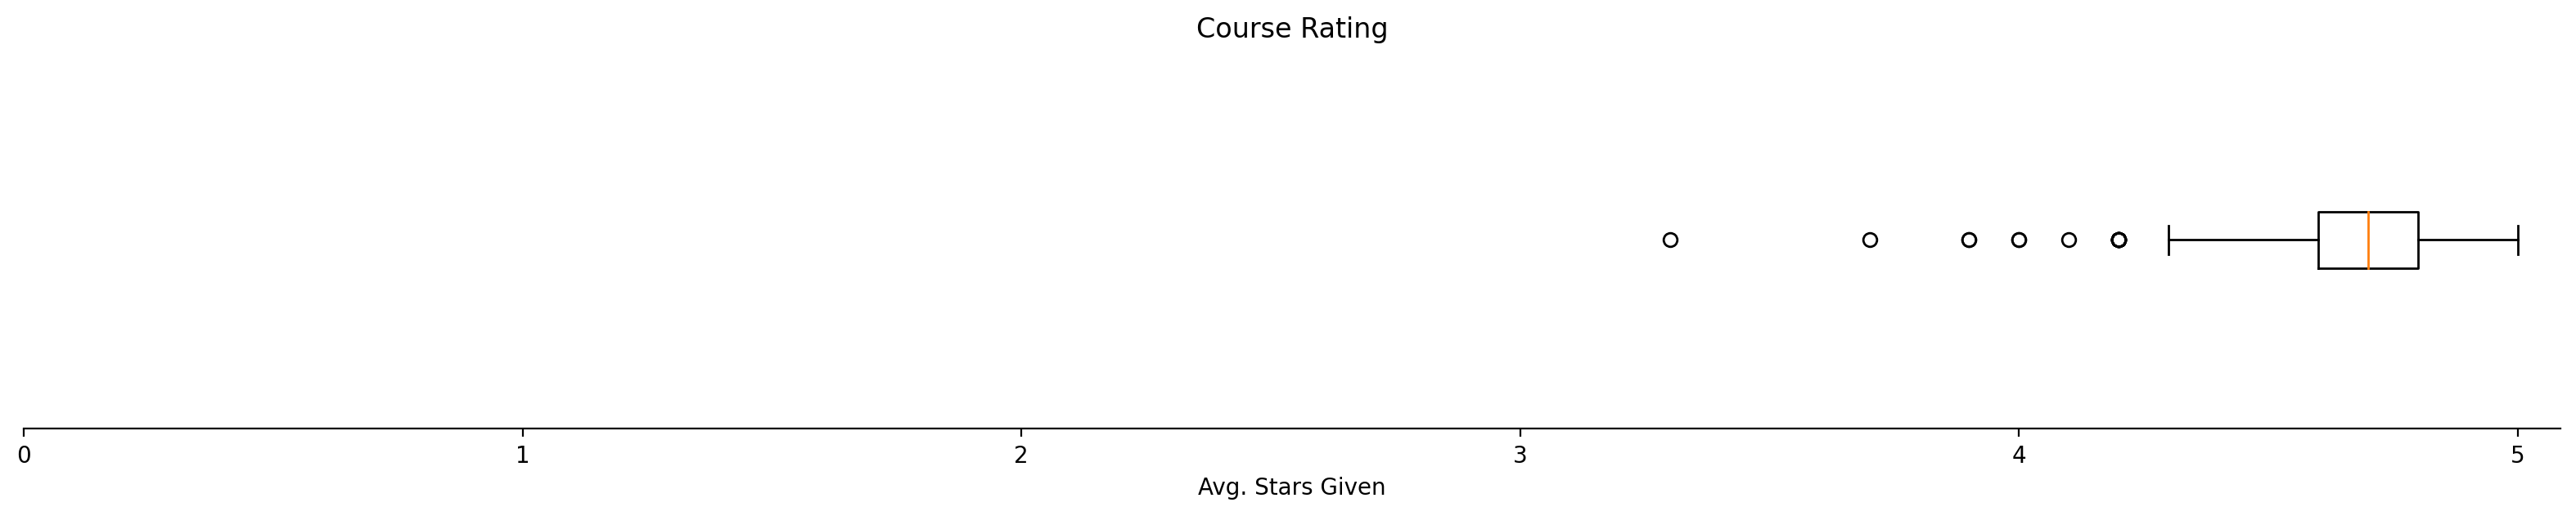

In [9]:
fig = plt.figure(figsize=(20,3), dpi=200)
ax = plt.gca()
ax.boxplot(data['course_rating'],vert=False)
ax.yaxis.set_major_formatter(plt.NullFormatter())
ax.yaxis.set_major_locator(plt.NullLocator())
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Course Rating')
ax.set_xlabel('Avg. Stars Given')
ax.set_xlim(xmin=0);

While lower outliers are present in this feature, there's no indication that this data is flawed in any manner, as ratings of 3.3 or higher fall within the normal range.

### Course Students Enrolled

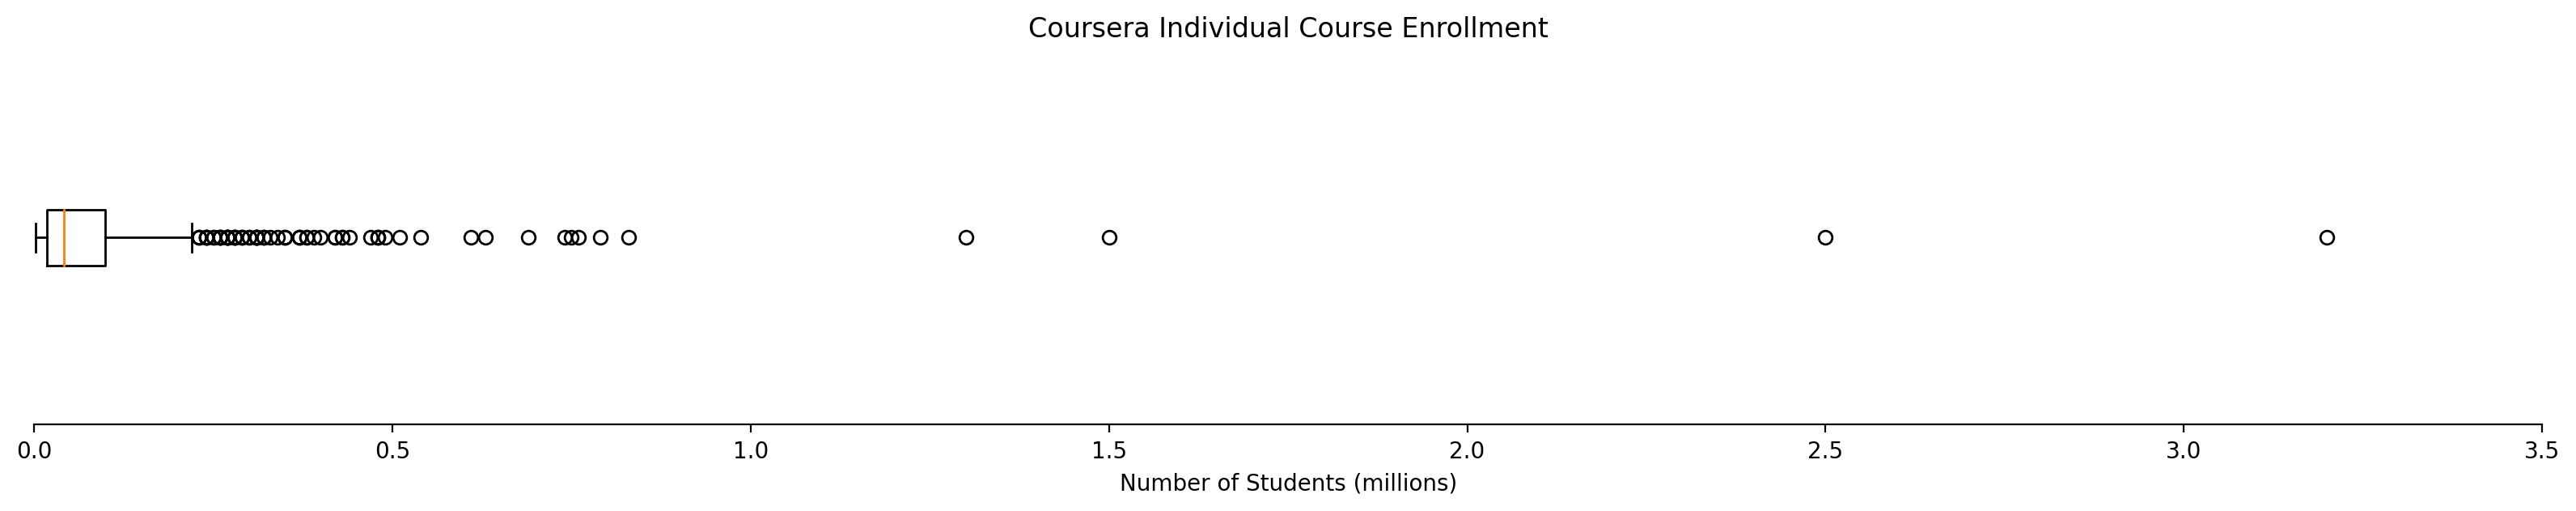

In [10]:
fig = plt.figure(figsize=(20,3),dpi=200)
ax = plt.gca()
ax.boxplot(data['course_students_enrolled_numeric'], vert=False)
ax.yaxis.set_major_formatter(plt.NullFormatter())
ax.yaxis.set_major_locator(plt.NullLocator())
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: x / 1E6))
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Number of Students (millions)')
ax.set_title('Coursera Individual Course Enrollment')
ax.set_xlim(xmin=0, xmax=3.5E6);

In [11]:
q1,q3 = np.percentile(data['course_students_enrolled_numeric'],[25,75])
iqr = q3 - q1
data[data['course_students_enrolled_numeric'] > q3 + (1.5 * iqr)].sort_values(
'course_students_enrolled_numeric', ascending=False).head()

,course_title,course_organization,course_Certificate_type,course_rating,course_difficulty,course_students_enrolled,course_students_enrolled_numeric
564,Machine Learning,Stanford University,COURSE,4.9,Mixed,3.2m,3200000.0
815,The Science of Well-Being,Yale University,COURSE,4.9,Mixed,2.5m,2500000.0
688,Python for Everybody,University of Michigan,SPECIALIZATION,4.8,Beginner,1.5m,1500000.0
674,Programming for Everybody (Getting Started wit...,University of Michigan,COURSE,4.8,Mixed,1.3m,1300000.0
196,Data Science,Johns Hopkins University,SPECIALIZATION,4.5,Beginner,830k,830000.0


There seem to be nothing that would indicate errors in the data. Even among the largest outliers, given the size of Coursera's total users, the prestige of the publishing organizations and the demand for MOOC's (especially for Data Science, ML and Python) such enrollment sizes are probable.

# Exploratory Analysis

### Observations and Features

In [12]:
data.shape[0]

891

In [13]:
list(data.columns)

['course_title',
 'course_organization',
 'course_Certificate_type',
 'course_rating',
 'course_difficulty',
 'course_students_enrolled',
 'course_students_enrolled_numeric']

There are 2 numeric features (course_students_enrolled and course_rating) and 4 categorical features (course_title, course_organization, course_Certificate_type and course_difficulty).

# Organizations

### Number of Organizations

In [14]:
len(data['course_organization'].unique())

154

### Number of Organizations that Published 1 course

In [15]:
(data['course_organization'].value_counts() == 1).sum()

49

### Top 20 Organizations by Number of Courses

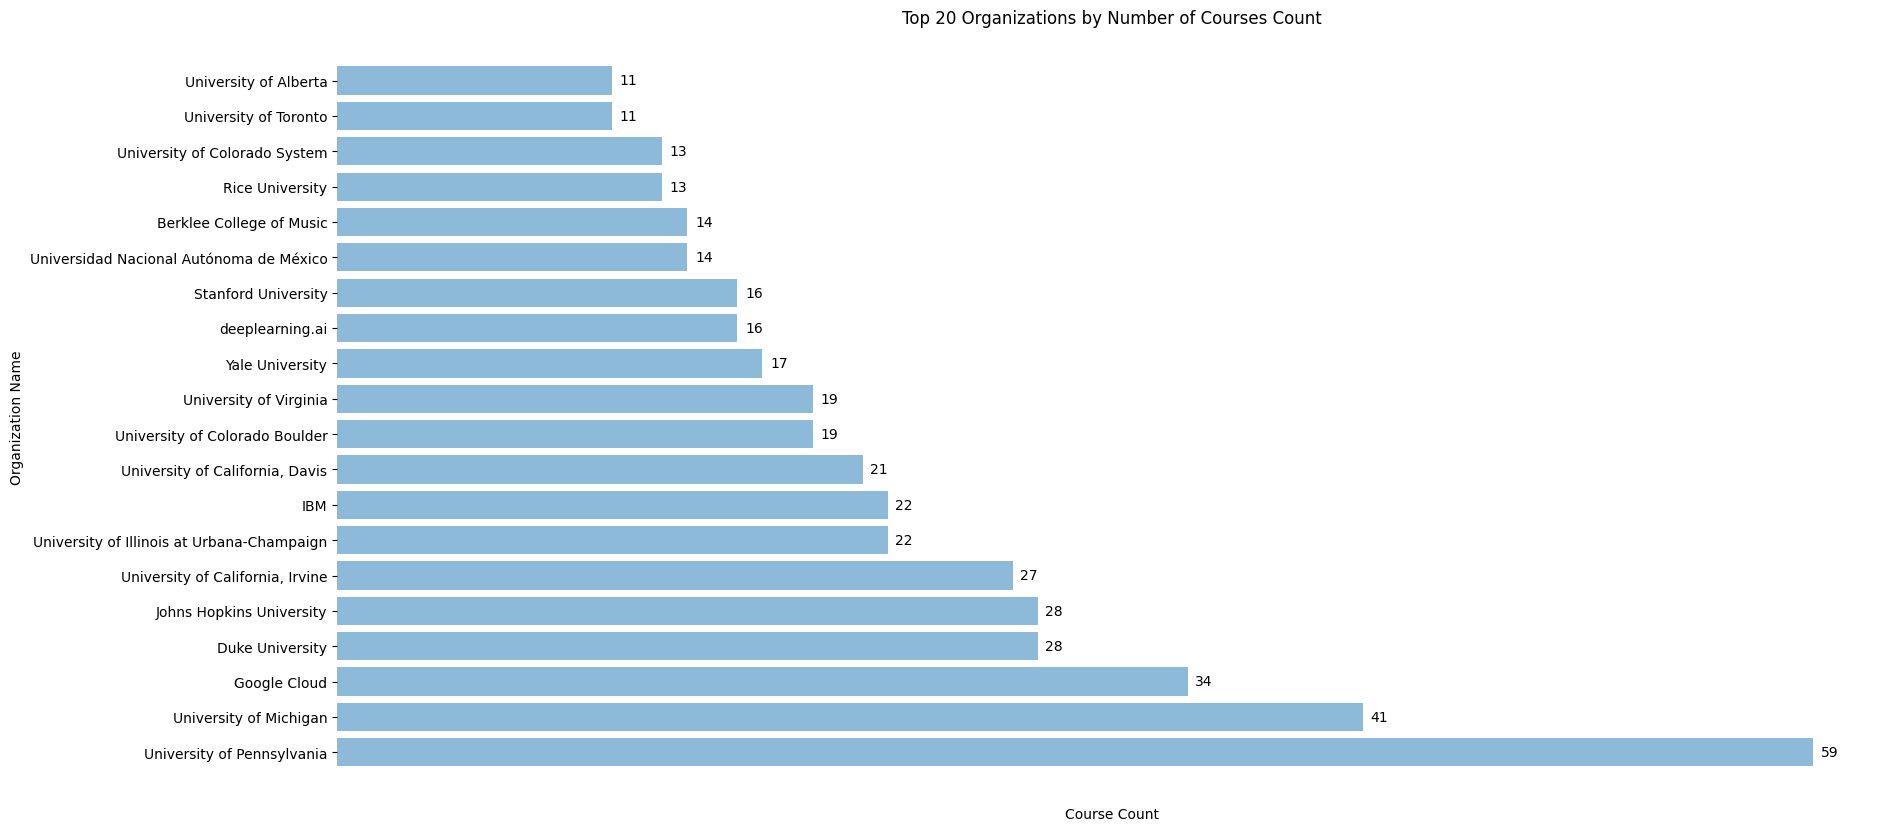

In [16]:
org_num = data.groupby('course_organization')['course_organization'].count().sort_values(ascending=False)
top_20_no_courses = org_num.iloc[:20]
fig, ax = plt.subplots(figsize=(20,10))
ax.barh(top_20_no_courses.index, top_20_no_courses, alpha=0.5)
for i in range(20):
    ax.text(x=top_20_no_courses[i]+0.3, y=i, s=top_20_no_courses[i], va='center')
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.xaxis.set_major_locator(plt.NullLocator())
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_title('Top 20 Organizations by Number of Courses Count')
ax.set_ylabel('Organization Name')
ax.set_xlabel('Course Count');

### Top 20 Organizations by Course Enrollment

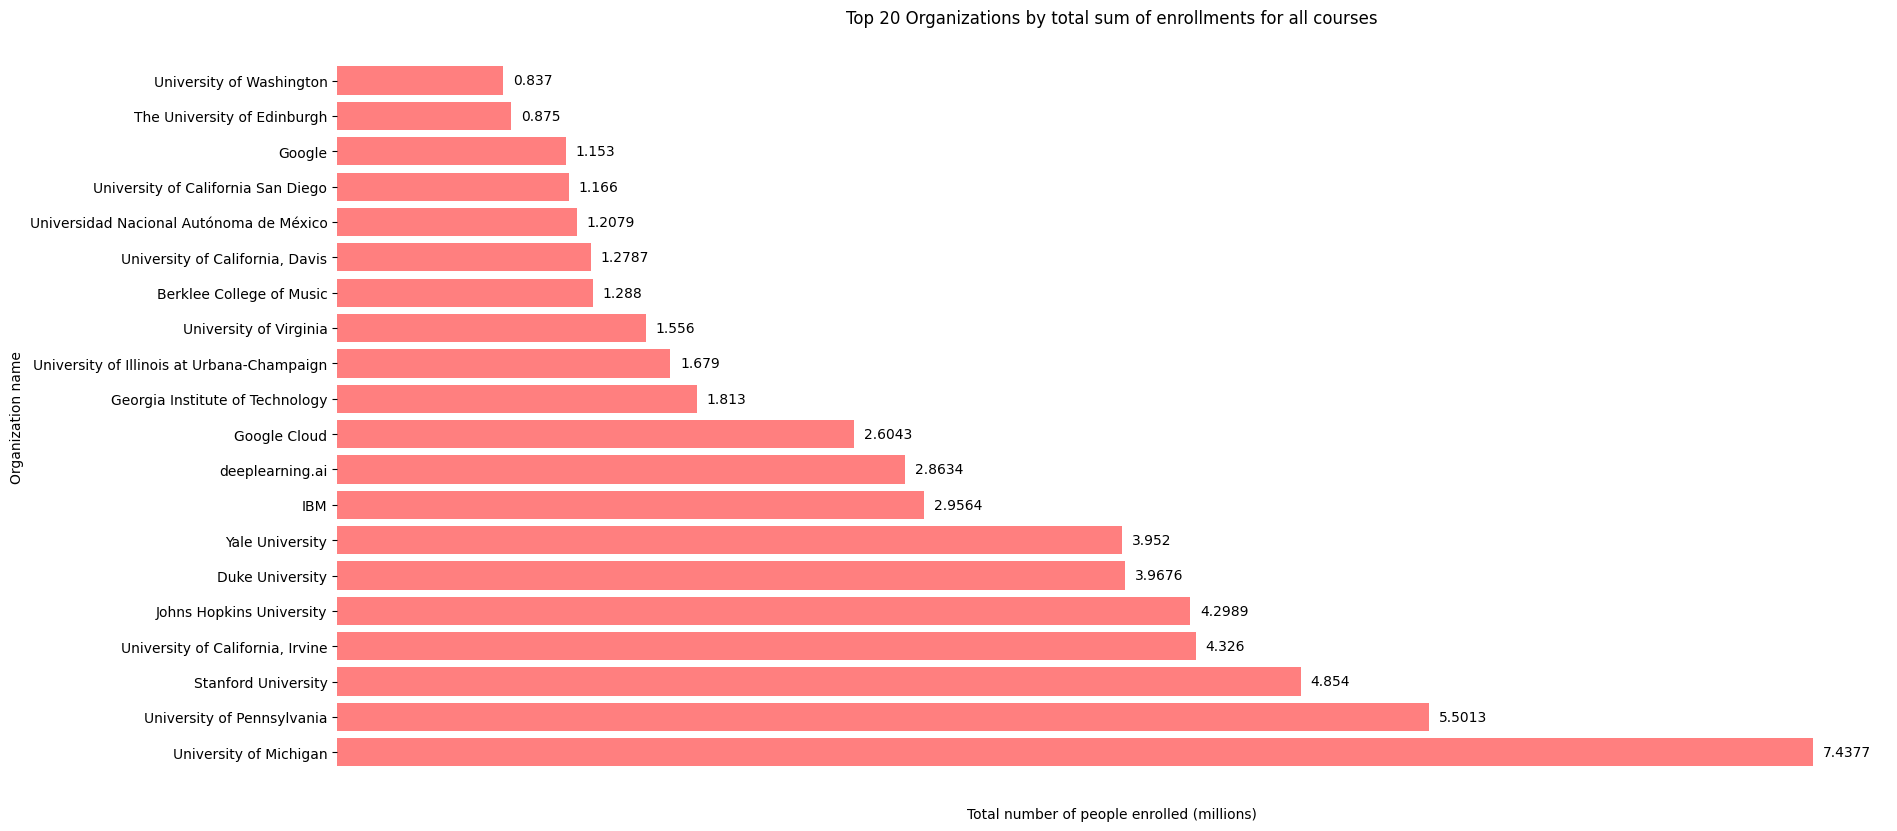

In [17]:
enroll_by_org = data.groupby('course_organization')['course_students_enrolled_numeric'].sum().sort_values(ascending=False)
top_20_enroll = enroll_by_org[:20]
fig, ax = plt.subplots(figsize=(20,10))
ax.barh(top_20_enroll.index, top_20_enroll, alpha=0.5, color='red')
for i in range(20):
    ax.text(x=top_20_enroll[i]+5E4, y=i, s=f'{top_20_enroll[i]/1E6}', va='center')
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.xaxis.set_major_locator(plt.NullLocator())
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_title('Top 20 Organizations by total sum of enrollments for all courses')
ax.set_ylabel('Organization name')
ax.set_xlabel('Total number of people enrolled (millions)');

### 20 Least Popular Organizations by Total Enrollment

In [18]:
least_popular_orgs = pd.DataFrame(
    data.groupby('course_organization')['course_students_enrolled_numeric'].sum().sort_values()).head(20)
least_popular_orgs

,course_students_enrolled_numeric
course_organization,
Automation Anywhere,2200.0
Peter the Great St. Petersburg Polytechnic University,2400.0
University of New Mexico,5500.0
ESCP Business School,6500.0
UCL School of Management,7800.0
Novosibirsk State University,8200.0
Crece con Google,8800.0
Palo Alto Networks,9100.0
Fundação Instituto de Administração,9200.0


In [19]:
data[data['course_organization'].isin(least_popular_orgs.index)]

,course_title,course_organization,course_Certificate_type,course_rating,course_difficulty,course_students_enrolled,course_students_enrolled_numeric
0,(ISC)² Systems Security Certified Practitioner...,(ISC)²,SPECIALIZATION,4.7,Beginner,5.3k,5300.0
20,Access Controls,(ISC)²,COURSE,4.6,Beginner,2.9k,2900.0
36,Agile и Scrum в работе над проектами и продуктами,ScrumTrek,COURSE,4.9,Beginner,12k,12000.0
68,Arts and Culture Strategy,National Arts Strategies,COURSE,4.6,Mixed,15k,15000.0
78,BIM Fundamentals for Engineers,National Taiwan University,COURSE,4.6,Beginner,13k,13000.0
166,Corporate Strategy,UCL School of Management,COURSE,4.8,Beginner,7.8k,7800.0
179,Curanderismo: Traditional Healing Using Plants,University of New Mexico,COURSE,4.6,Beginner,5.5k,5500.0
214,Dermatology: Trip to skin,Novosibirsk State University,COURSE,4.4,Beginner,8.2k,8200.0
265,Enterprise Architecture,Peter the Great St. Petersburg Polytechnic Uni...,COURSE,4.4,Beginner,2.4k,2400.0
373,Get Interactive: Practical Teaching with Techn...,Bloomsbury Learning Exchange,COURSE,4.7,Beginner,14k,14000.0


# Dificulty Levels

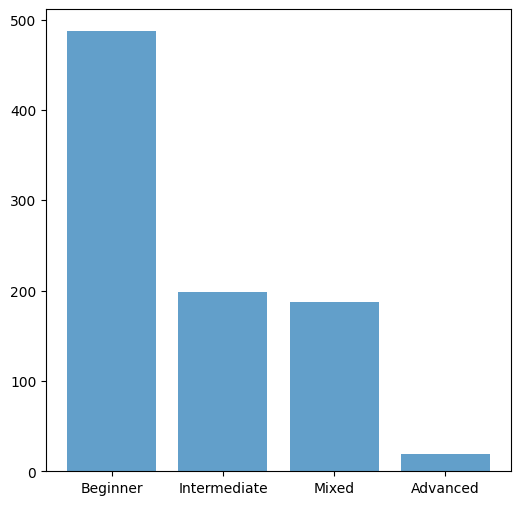

In [20]:
diffs = data['course_difficulty'].value_counts()
fig, ax = plt.subplots(figsize=(6,6))
ax.bar(diffs.index, diffs, alpha=0.7);

### Students Enrolled per Course Difficulty

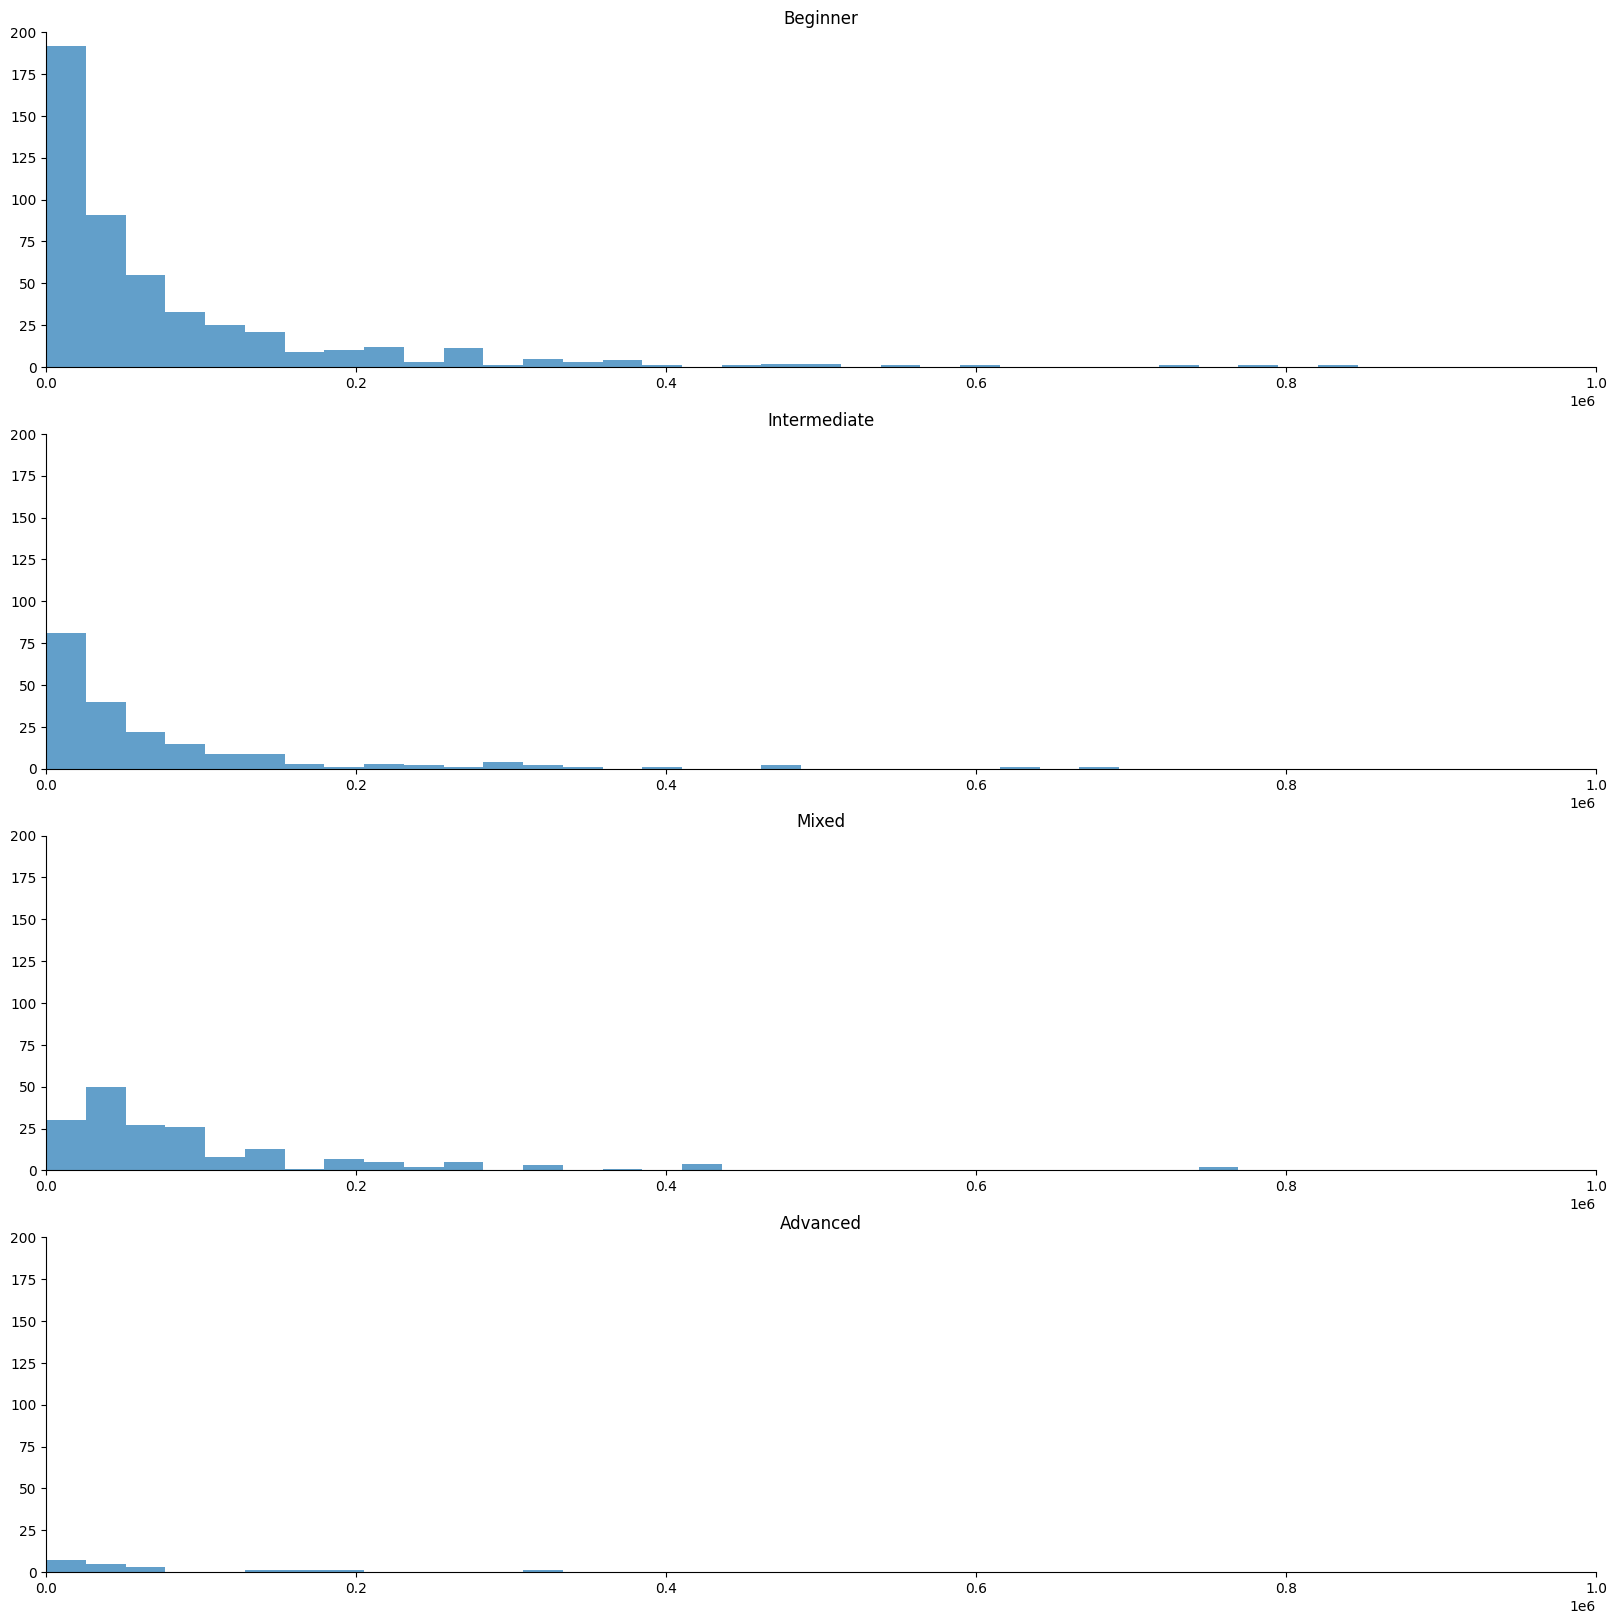

In [21]:
def hist_x_by_y(df,x,y,bins=None,ylim=None,xlim=None,figsize=(20,20)):
    xs = df[y].unique()
    fig, ax = plt.subplots(len(xs),1,figsize=figsize)
    for i in range(len(xs)):
    
        ax[i].hist(df[df[y] == xs[i]]
        [x], histtype='stepfilled', bins=bins, alpha=0.7)
        ax[i].set_ylim(ylim)
        ax[i].set_xlim(xlim)
        ax[i].set_title(f'{xs[i]}'.capitalize())
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
hist_x_by_y(data,'course_students_enrolled_numeric','course_difficulty',bins=np.linspace(0,1E6,40),ylim=(0,200),xlim=(0,1E6))
fig.suptitle('Students Enrolled per Course Difficulty Level');

# Certificates

### Certificate Type Distribution

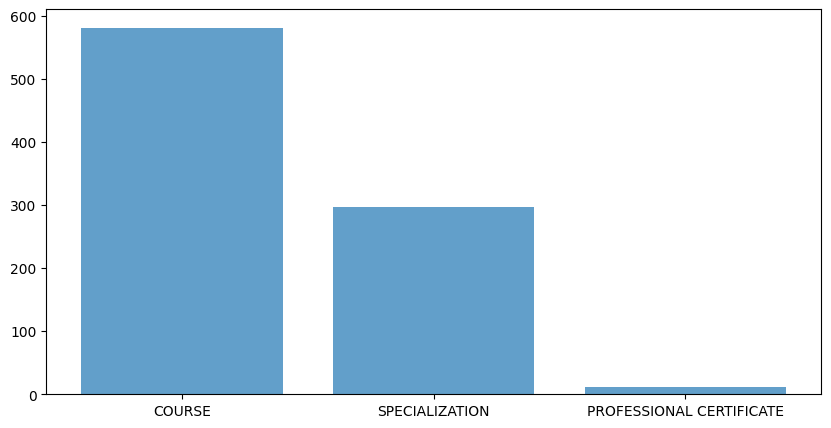

In [22]:
certificate_count = data['course_Certificate_type'].value_counts()
fig, ax = plt.subplots(figsize=(10,5))
ax.bar(certificate_count.index, certificate_count, alpha=0.7);

### Mean and Median Total Number of Enrollments by Certificate Type

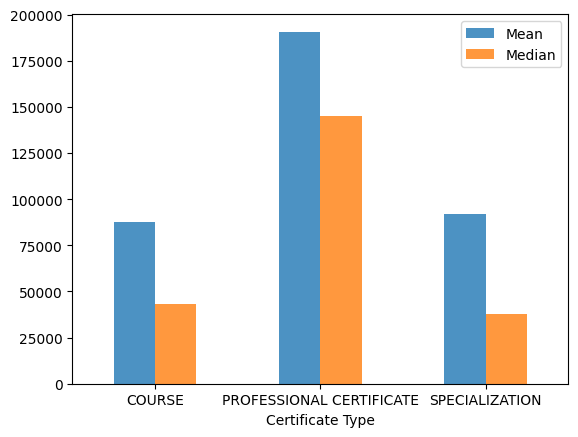

In [23]:
mean_enrollment_by_cert_type = data.groupby('course_Certificate_type')['course_students_enrolled_numeric'].mean()
median_enrollment_by_cert_type = data.groupby('course_Certificate_type')['course_students_enrolled_numeric'].median()
mean_median_en_by_cert = pd.DataFrame({'Mean' : mean_enrollment_by_cert_type.values,
                                      'Median' : median_enrollment_by_cert_type.values},
                                      index=mean_enrollment_by_cert_type.index)
ax = mean_median_en_by_cert.plot(kind='bar', rot=0, alpha=0.8)
ax.set_xlabel('Certificate Type');
#ax.set_title()

In [24]:
data[data['course_Certificate_type'] == 'PROFESSIONAL CERTIFICATE']

,course_title,course_organization,course_Certificate_type,course_rating,course_difficulty,course_students_enrolled,course_students_enrolled_numeric
65,Arizona State University TESOL,Arizona State University,PROFESSIONAL CERTIFICATE,4.9,Beginner,150k,150000.0
142,Cloud Engineering with Google Cloud,Google Cloud,PROFESSIONAL CERTIFICATE,4.7,Intermediate,310k,310000.0
192,Data Engineering with Google Cloud,Google Cloud,PROFESSIONAL CERTIFICATE,4.6,Intermediate,120k,120000.0
391,Google IT Automation with Python,Google,PROFESSIONAL CERTIFICATE,4.7,Beginner,93k,93000.0
392,Google IT Support,Google,PROFESSIONAL CERTIFICATE,4.8,Beginner,350k,350000.0
416,IBM AI Engineering,IBM,PROFESSIONAL CERTIFICATE,4.6,Intermediate,140k,140000.0
418,IBM Applied AI,IBM,PROFESSIONAL CERTIFICATE,4.6,Beginner,220k,220000.0
420,IBM Data Science,IBM,PROFESSIONAL CERTIFICATE,4.6,Beginner,480k,480000.0
709,SAS Programmer,SAS,PROFESSIONAL CERTIFICATE,4.8,Beginner,370k,370000.0
710,SAS Visual Business Analytics,SAS,PROFESSIONAL CERTIFICATE,4.6,Beginner,2.6k,2600.0


It's hard to determine wether it's the certificate type or other variables that lead to good enrollment performance.

# Ratings

### Rating distribution

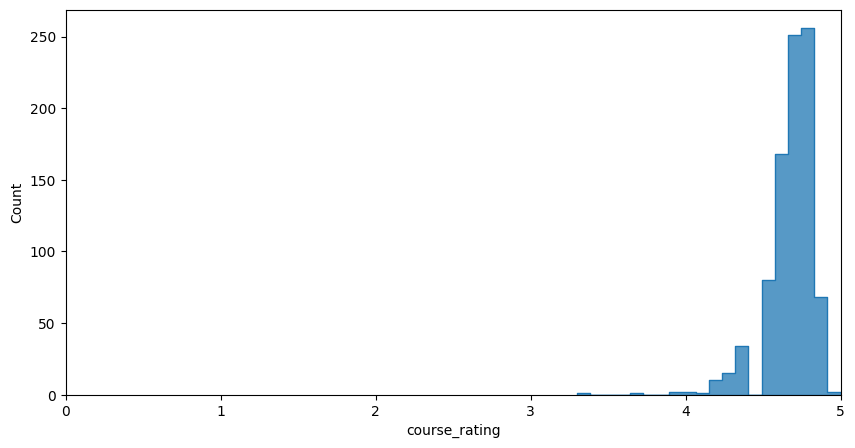

In [25]:
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(data=data, x='course_rating', ax=ax, element='step', bins=20)
ax.set_xlim(0,5);

## Ratings Distributions of Different Certificate Types

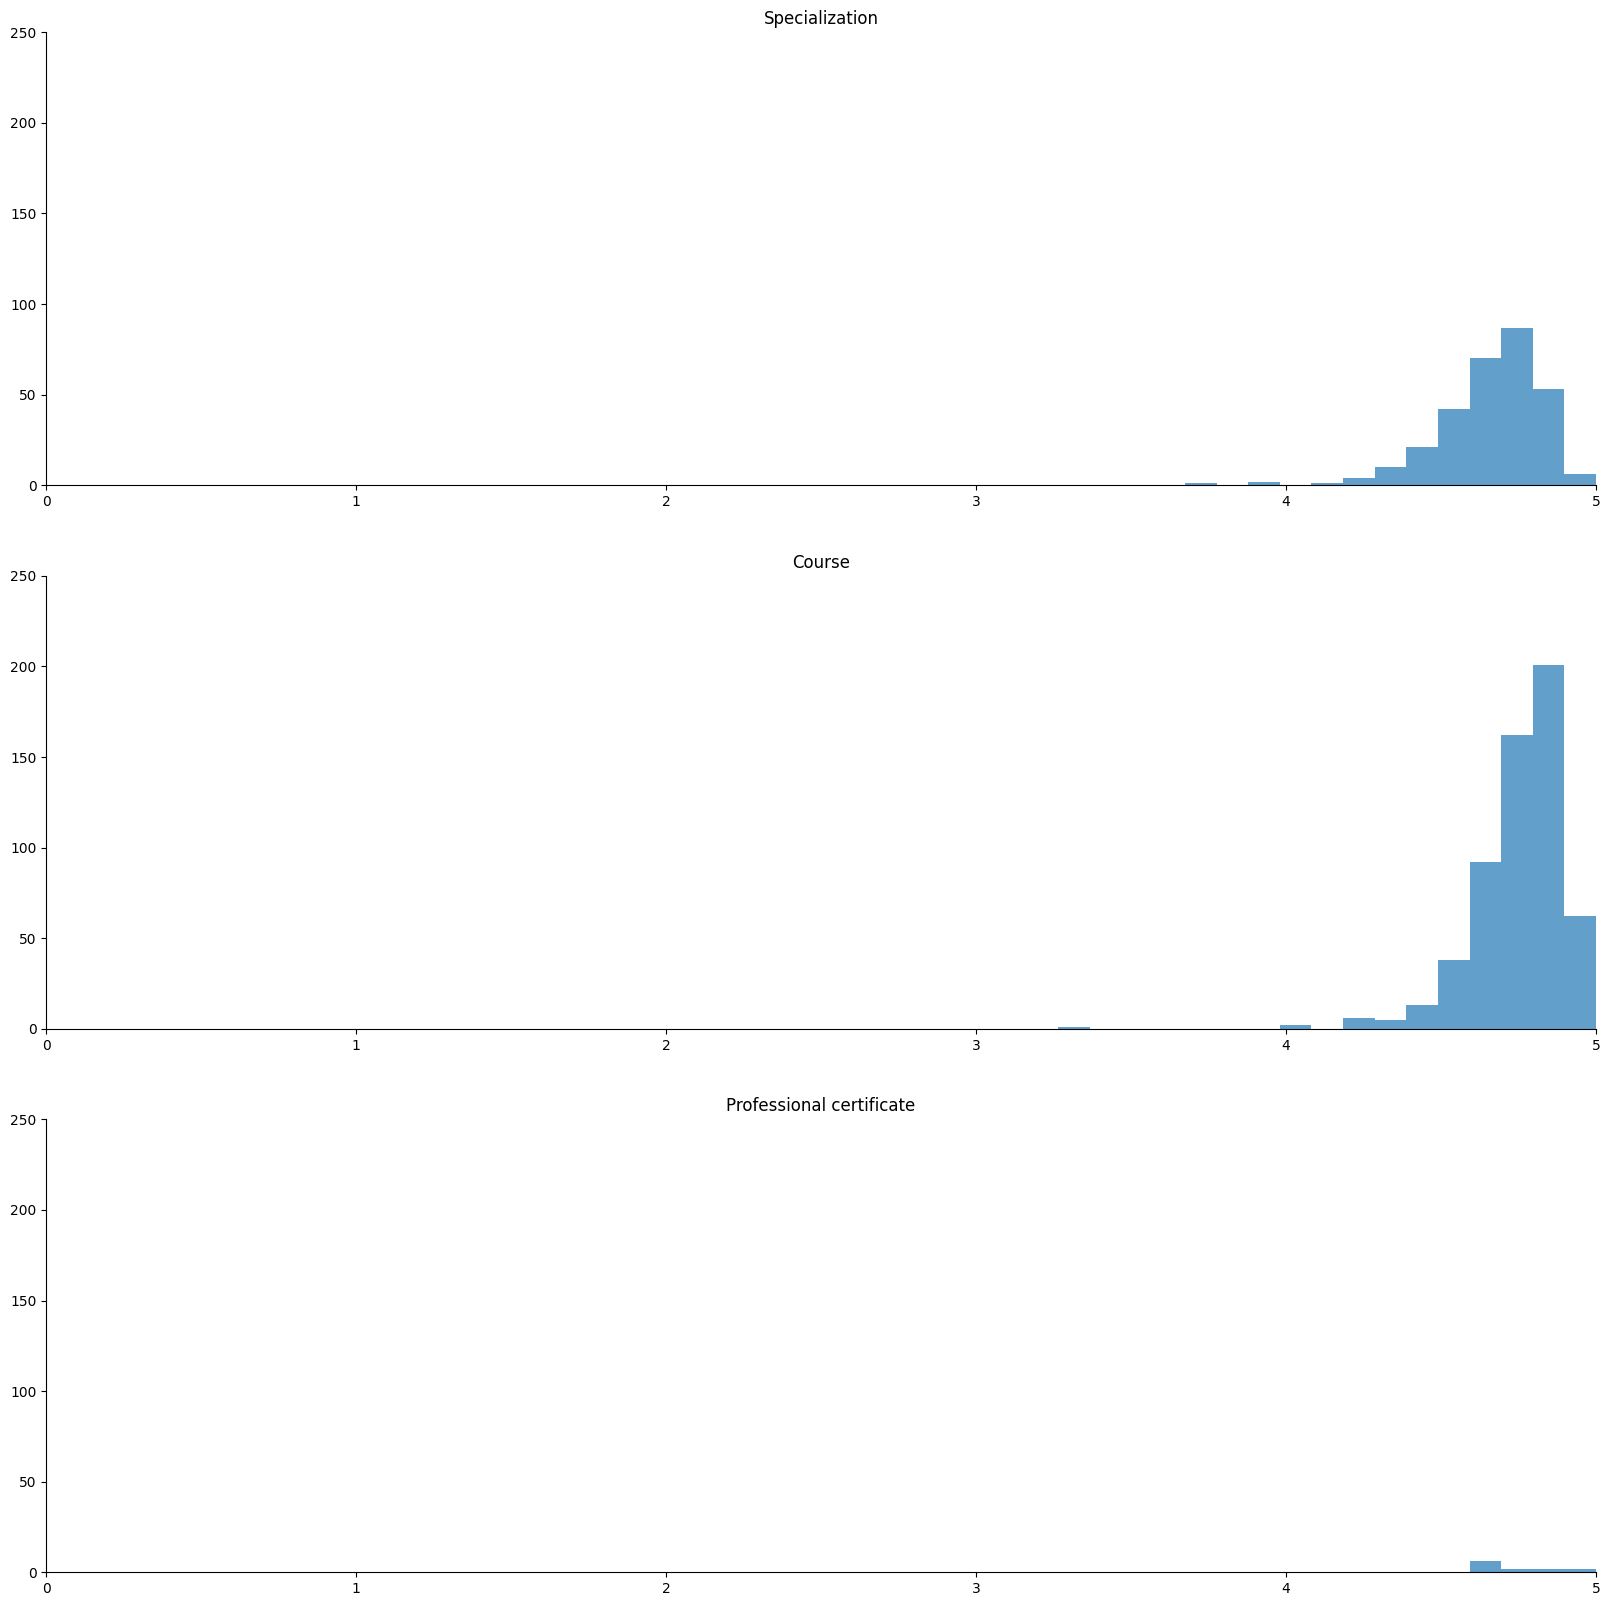

In [26]:
hist_x_by_y(data,'course_rating','course_Certificate_type',bins=np.linspace(0,5,50),ylim=(0,250),xlim=(0,5))

## Rating per Course Difficulty

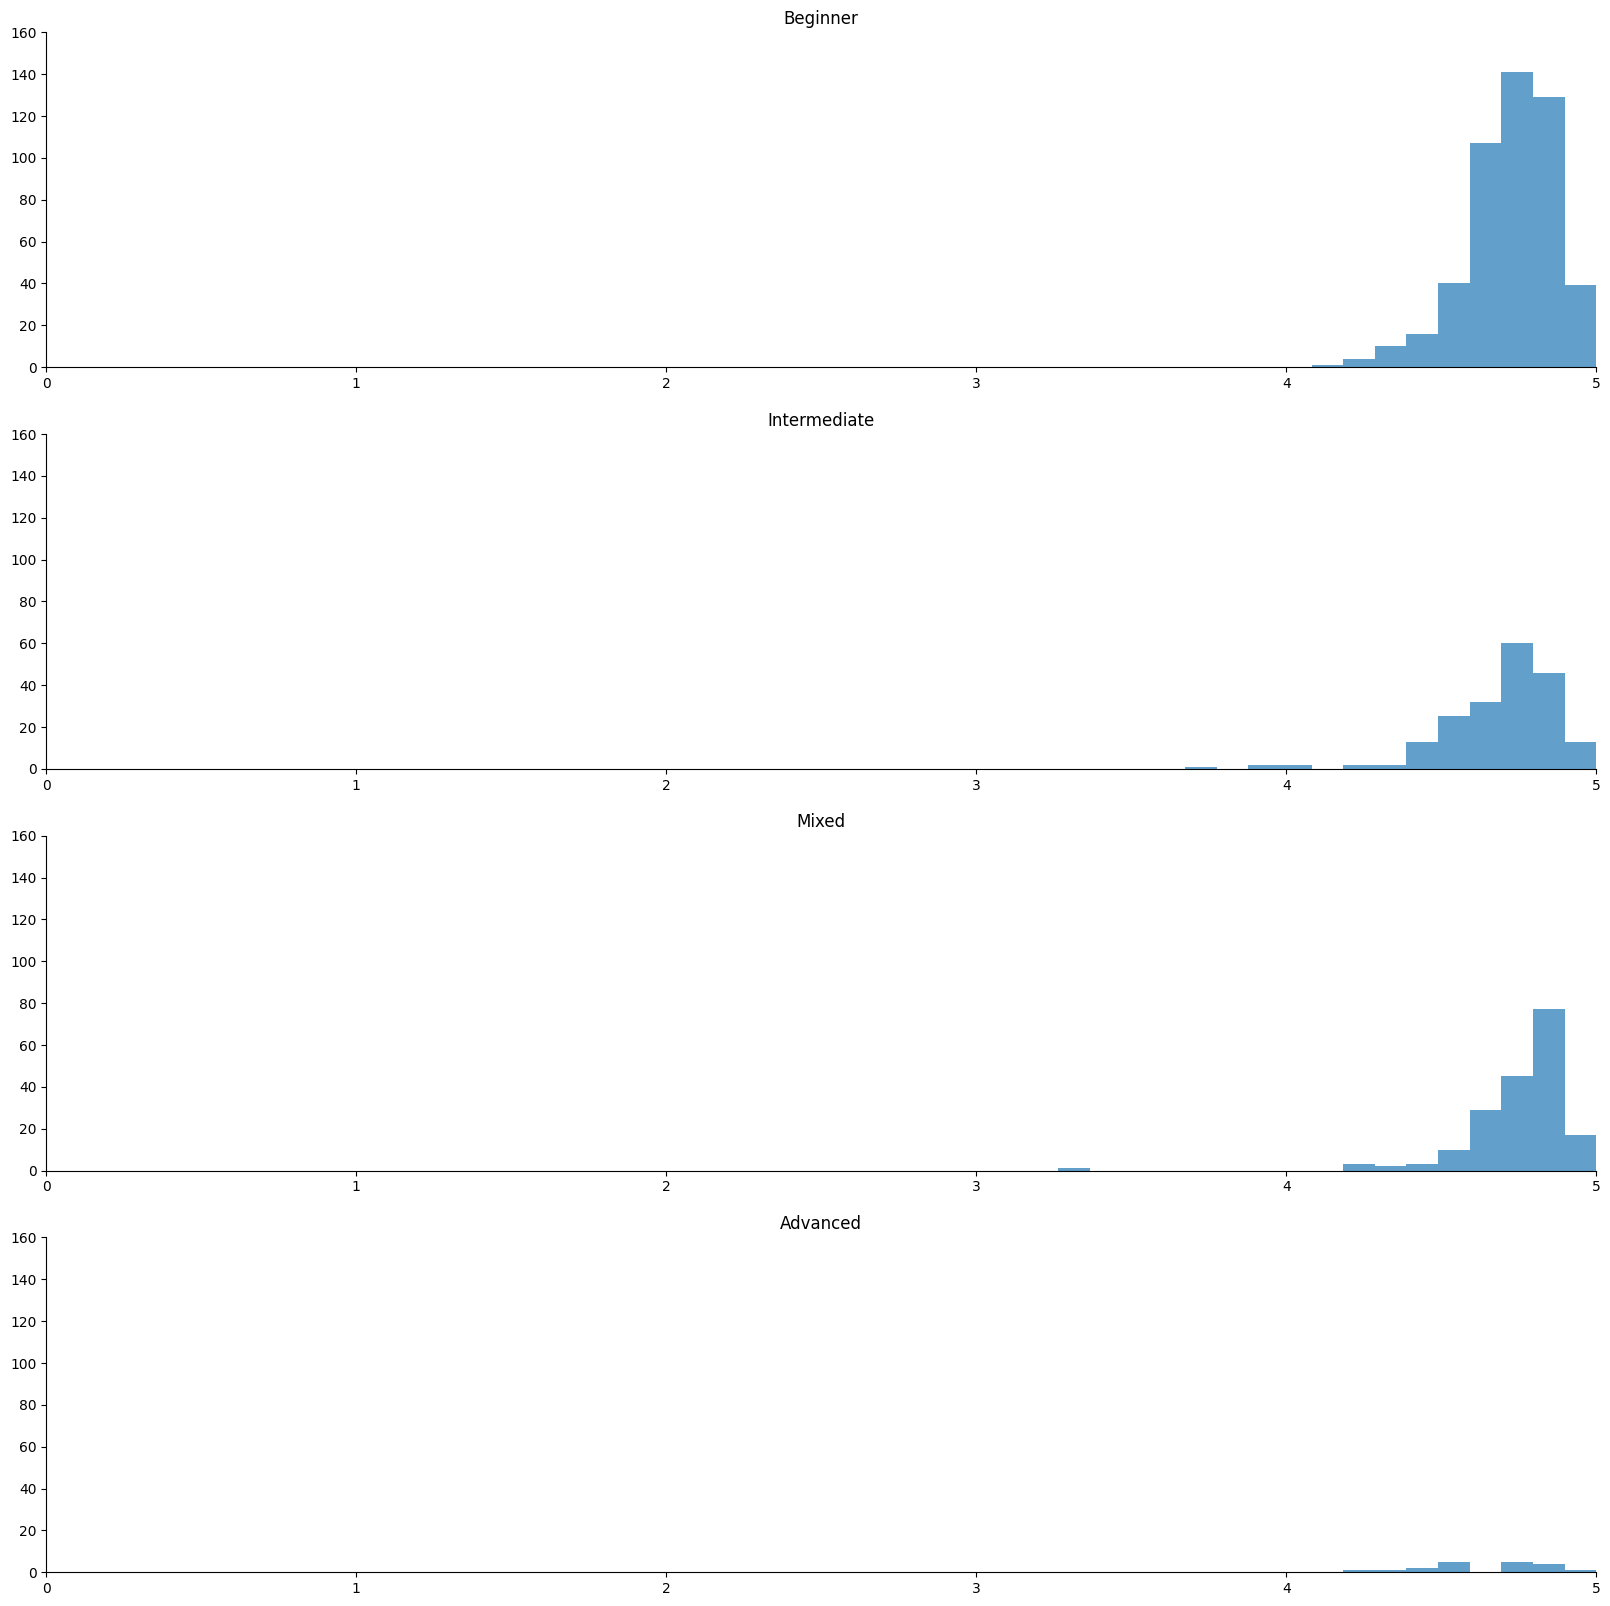

In [27]:
hist_x_by_y(data,'course_rating','course_difficulty',bins=np.linspace(0,5,50),ylim=(0,160),xlim=(0,5))

# Organization Type

There is a possibility to derive the types of organizations from 'course_organization' column. 

Selecting some keywords:

In [28]:
data[np.invert(data['course_organization'].str.contains(
'|'.join(['Universi', 'Institute', 'School','College'])))]['course_organization'].unique()

array(['(ISC)²', 'deeplearning.ai', 'IBM', 'Amazon Web Services',
       'Google Cloud', 'Atlassian', 'ScrumTrek',
       'The Museum of Modern Art', 'National Arts Strategies', 'Autodesk',
       'Google - Spectrum Sharing', 'INSEAD', 'ConsenSys Academy',
       'HEC Paris', 'Osmosis', 'Cisco', 'LearnQuest', 'Google', 'PwC',
       'Ticket for Change', 'Tecnológico de Monterrey',
       'American Museum of Natural History',
       'École Polytechnique Fédérale de Lausanne', 'Sciences Po',
       'Bloomsbury Learning Exchange', 'SAS', 'Automation Anywhere',
       'Kalshoven-Gieskes Forum', 'JetBrains', 'Cloudera', 'VMware',
       'The Linux Foundation', 'Palo Alto Networks', 'MathWorks',
       'E-Learning Development Fund', 'BCG', 'HubSpot Academy',
       'Crece con Google', 'Fundação Instituto de Administração',
       'École des Ponts ParisTech', 'Unity', 'École Polytechnique',
       'Mail.Ru Group'], dtype=object)

Making sure that 'School' keyword links to actual higher education schools.

In [29]:
data[data['course_organization'].str.contains('School')]['course_organization'].unique()

array(['Indian School of Business',
       'National Research University Higher School of Economics',
       'Copenhagen Business School', 'London Business School',
       'IE Business School', 'IESE Business School',
       'UCL School of Management', 'ESADE Business and Law School',
       'EDHEC Business School', 'ESSEC Business School',
       'ESCP Business School', 'IE School of Architecture & Design',
       'Icahn School of Medicine at Mount Sinai',
       'Relay Graduate School of Education'], dtype=object)

Keywords: INSEAD, HEC Paris, Tecnológico de Monterrey, École, Fundação Instituto de Administração were checked and excluded manually.

In [30]:
keywords = ['Universi', 'Institute', 'School','College',
'INSEAD', 'HEC Paris', 'Tecnológico de Monterrey', 'École',
'Fundação Instituto de Administração']

non_unis = data[np.invert(data['course_organization'].str.contains(
'|'.join(keywords)))]['course_organization'].unique()

In [31]:
non_unis

array(['(ISC)²', 'deeplearning.ai', 'IBM', 'Amazon Web Services',
       'Google Cloud', 'Atlassian', 'ScrumTrek',
       'The Museum of Modern Art', 'National Arts Strategies', 'Autodesk',
       'Google - Spectrum Sharing', 'ConsenSys Academy', 'Osmosis',
       'Cisco', 'LearnQuest', 'Google', 'PwC', 'Ticket for Change',
       'American Museum of Natural History', 'Sciences Po',
       'Bloomsbury Learning Exchange', 'SAS', 'Automation Anywhere',
       'Kalshoven-Gieskes Forum', 'JetBrains', 'Cloudera', 'VMware',
       'The Linux Foundation', 'Palo Alto Networks', 'MathWorks',
       'E-Learning Development Fund', 'BCG', 'HubSpot Academy',
       'Crece con Google', 'Unity', 'Mail.Ru Group'], dtype=object)

In [32]:
data['organization_type'] = np.where(data['course_organization'].isin(non_unis),'Other','Higher Education')
data.head()

,course_title,course_organization,course_Certificate_type,course_rating,course_difficulty,course_students_enrolled,course_students_enrolled_numeric,organization_type
0,(ISC)² Systems Security Certified Practitioner...,(ISC)²,SPECIALIZATION,4.7,Beginner,5.3k,5300.0,Other
1,A Crash Course in Causality: Inferring Causal...,University of Pennsylvania,COURSE,4.7,Intermediate,17k,17000.0,Higher Education
2,A Crash Course in Data Science,Johns Hopkins University,COURSE,4.5,Mixed,130k,130000.0,Higher Education
3,A Law Student's Toolkit,Yale University,COURSE,4.7,Mixed,91k,91000.0,Higher Education
4,A Life of Happiness and Fulfillment,Indian School of Business,COURSE,4.8,Mixed,320k,320000.0,Higher Education
